# Preprocessing Load Data

Import all dependencies

In [14]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install numpy
!pip install datetime




Make all necessary imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import sys


Preprocessing Function/Feature Engineering

In [11]:
def preprocess_load_data(file_path):
    """
    Preprocess the aggregated load data from ERCOT and add features useful for price prediction.
    
    Args:
        file_path (str): Path to the raw load data CSV file
        
    Returns:
        pd.DataFrame: Processed load data with engineered features
    """
    # Read the data
    load_df = pd.read_csv(file_path)
    
    # Convert SCED Time Stamp to datetime
    load_df['SCED Time Stamp'] = pd.to_datetime(load_df['SCED Time Stamp'])
    
    # Extract date and time components
    load_df['Date'] = load_df['SCED Time Stamp'].dt.date
    load_df['Hour'] = load_df['SCED Time Stamp'].dt.hour
    load_df['Minute'] = load_df['SCED Time Stamp'].dt.minute
    load_df['DayOfWeek'] = load_df['SCED Time Stamp'].dt.dayofweek
    load_df['Month'] = load_df['SCED Time Stamp'].dt.month
    load_df['IsWeekend'] = load_df['DayOfWeek'].isin([5, 6]).astype(int)
    
    # Create time-based features
    load_df['IsPeakHour'] = ((load_df['Hour'] >= 14) & (load_df['Hour'] <= 20)).astype(int)  # Peak hours 2 PM - 8 PM
    load_df['IsOffPeakHour'] = ((load_df['Hour'] >= 23) | (load_df['Hour'] <= 5)).astype(int)  # Off-peak hours 11 PM - 5 AM
    
    # Calculate load-based features
    load_df['LoadChange'] = load_df['AGG LOAD SUMMARY'].diff()  # Change in load from previous interval
    load_df['LoadChangePct'] = load_df['LoadChange'] / load_df['AGG LOAD SUMMARY'].shift(1)  # Percentage change
    
    # Calculate rolling statistics
    load_df['LoadMA4'] = load_df['AGG LOAD SUMMARY'].rolling(window=4).mean()  # 1-hour moving average
    load_df['LoadMA24'] = load_df['AGG LOAD SUMMARY'].rolling(window=24).mean()  # 6-hour moving average
    load_df['LoadStd4'] = load_df['AGG LOAD SUMMARY'].rolling(window=4).std()  # 1-hour standard deviation
    
    # Calculate load volatility
    load_df['LoadVolatility'] = load_df['LoadStd4'] / load_df['LoadMA4']
    
    # Create lagged features
    load_df['LoadLag1'] = load_df['AGG LOAD SUMMARY'].shift(1)  # Previous interval load
    load_df['LoadLag4'] = load_df['AGG LOAD SUMMARY'].shift(4)  # 1-hour ago load
    load_df['LoadLag24'] = load_df['AGG LOAD SUMMARY'].shift(24)  # 6-hours ago load
    
    # Create datetime index for merging
    load_df.set_index('SCED Time Stamp', inplace=True)
    
    # Drop rows with NaN values (from rolling calculations and lags)
    load_df.dropna(inplace=True)
    
    return load_df

Load in the Dataset and pass it into the preprocessing function


In [12]:
project_root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(project_root)
input_file = os.path.join(project_root, 'data', 'raw', 'load', '2d_Agg_Load_Summary-17-APR-25.csv')



load_df = preprocess_load_data(input_file)
load_df

,Repeated Hour Flag,SUM TELEM GEN MW,SUM TELEM DCTIE MW,AGG LOAD SUMMARY,Date,Hour,Minute,DayOfWeek,Month,IsWeekend,...,IsOffPeakHour,LoadChange,LoadChangePct,LoadMA4,LoadMA24,LoadStd4,LoadVolatility,LoadLag1,LoadLag4,LoadLag24
SCED Time Stamp,,,,,,,,,,,,,,,,,,,,,
2025-04-15 06:00:16,N,43975.45080,-10.0,43985.45080,2025-04-15,6,0,1,4,0,...,0,478.09330,0.010989,43248.763990,43967.078633,634.109803,0.014662,43507.35750,42266.24446,49444.95908
2025-04-15 06:15:10,N,44976.43267,-35.7,45012.13267,2025-04-15,6,15,1,4,0,...,0,1026.68187,0.023341,43870.312350,43850.656372,865.638442,0.019732,43985.45080,42525.93923,47806.26693
2025-04-15 06:30:11,N,45394.42735,-71.2,45465.62735,2025-04-15,6,30,1,4,0,...,0,453.49468,0.010075,44492.642080,43787.874173,902.699564,0.020289,45012.13267,42976.30843,46972.40012
2025-04-15 06:45:11,N,46006.21536,-70.7,46076.91536,2025-04-15,6,45,1,4,0,...,0,611.28801,0.013445,45135.031545,43768.615439,881.868987,0.019538,45465.62735,43507.35750,46539.12499
2025-04-15 07:00:13,N,46064.33395,-102.4,46166.73395,2025-04-15,7,0,1,4,0,...,0,89.81859,0.001949,45680.352333,43764.969254,543.584905,0.011900,46076.91536,43985.45080,46254.24239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-15 22:45:09,N,49065.31658,-158.4,49223.71658,2025-04-15,22,45,1,4,0,...,0,-713.96576,-0.014297,50244.210547,53907.559805,901.746656,0.017947,49937.68234,51810.20491,55963.11680
2025-04-15 23:00:12,N,48732.35007,-158.5,48890.85007,2025-04-15,23,0,1,4,0,...,1,-332.86651,-0.006762,49624.941080,53594.578497,701.024537,0.014126,49223.71658,51367.92794,56402.40146
2025-04-15 23:15:09,N,47988.89619,-158.5,48147.39619,2025-04-15,23,15,1,4,0,...,1,-743.45388,-0.015206,49049.911295,53245.240067,743.455826,0.015157,48890.85007,50447.51533,56531.51851


In [13]:
def analyze_load_data(load_df):
    """
    Perform basic analysis on the load data.
    
    Args:
        load_df (pd.DataFrame): Processed load data
    """
    # Check for missing values
    print("Missing values per column:")
    print(load_df.isnull().sum())
    
    # Check for duplicate timestamps
    print("\nNumber of duplicate timestamps:", load_df.index.duplicated().sum())
    
    # Basic statistics
    print("\nBasic statistics of AGG LOAD SUMMARY:")
    print(load_df['AGG LOAD SUMMARY'].describe())
    
    # Calculate hourly statistics
    hourly_stats = load_df.groupby('Hour')['AGG LOAD SUMMARY'].agg(['mean', 'std', 'min', 'max'])
    print("\nHourly Load Statistics:")
    print(hourly_stats)

In [14]:
analyze_load_data(load_df)

Missing values per column:
Repeated Hour Flag    0
SUM TELEM GEN MW      0
SUM TELEM DCTIE MW    0
AGG LOAD SUMMARY      0
Date                  0
Hour                  0
Minute                0
DayOfWeek             0
Month                 0
IsWeekend             0
IsPeakHour            0
IsOffPeakHour         0
LoadChange            0
LoadChangePct         0
LoadMA4               0
LoadMA24              0
LoadStd4              0
LoadVolatility        0
LoadLag1              0
LoadLag4              0
LoadLag24             0
dtype: int64

Number of duplicate timestamps: 0

Basic statistics of AGG LOAD SUMMARY:
count       72.000000
mean     51811.430546
std       3379.272823
min      43985.450800
25%      49589.363643
50%      52199.185845
75%      54258.069212
max      57010.678500
Name: AGG LOAD SUMMARY, dtype: float64

Hourly Load Statistics:
              mean         std          min          max
Hour                                                    
6     45135.031545  881.8689

In [16]:
def visualize_load_data(load_df):
    """
    Create visualizations for the load data.
    
    Args:
        load_df (pd.DataFrame): Processed load data
    """
    # Time series plot
    plt.figure(figsize=(15, 6))
    plt.plot(load_df.index, load_df['AGG LOAD SUMMARY'])
    plt.title('ERCOT System Load Over Time')
    plt.xlabel('Time')
    plt.ylabel('Load (MW)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=load_df['AGG LOAD SUMMARY'])
    plt.title('Distribution of System Load')
    plt.ylabel('Load (MW)')
    plt.show()

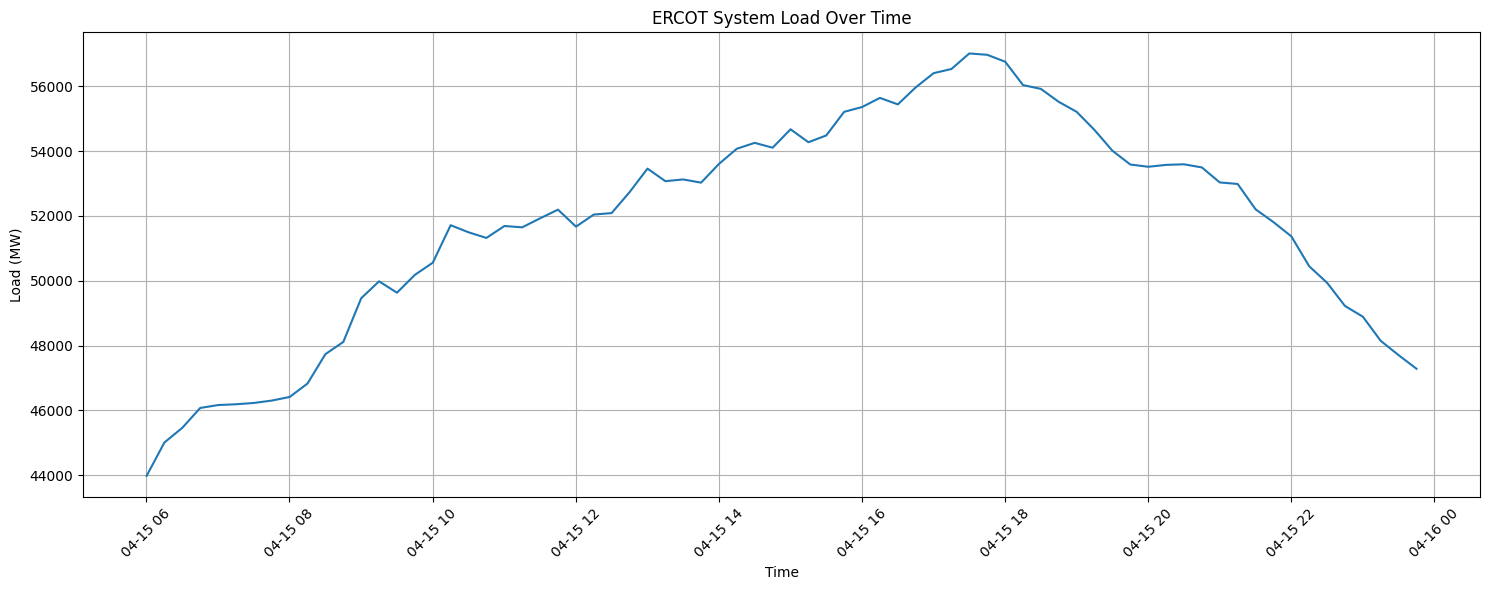

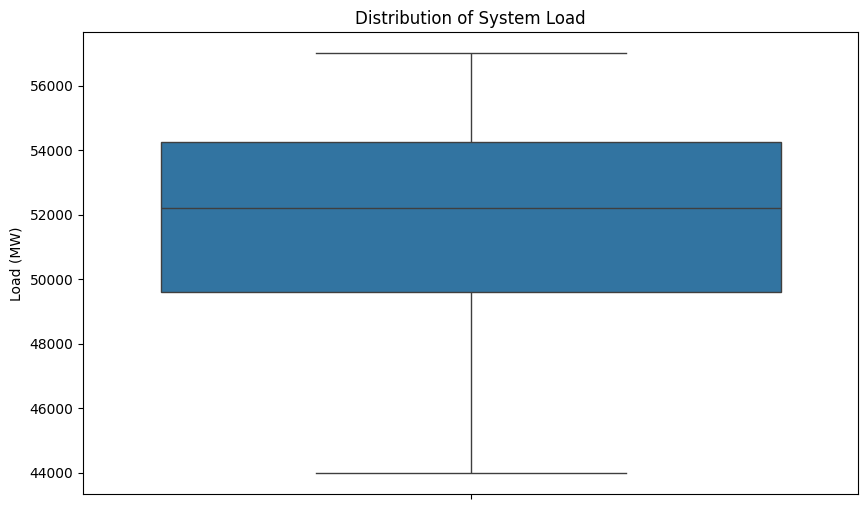

In [17]:
visualize_load_data(load_df)

Function to save DF to output path

In [18]:
def save_processed_data(load_df, output_path):
    """
    Save the processed data to a CSV file.
    
    Args:
        load_df (pd.DataFrame): Processed load data
        output_path (str): Path to save the processed data
    """
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    load_df.to_csv(output_path)
    print(f"Processed data saved to {output_path}")

In [19]:
output_file = os.path.join(project_root, 'data', 'processed', 'load', 'processed_aggregated_load.csv')
save_processed_data(load_df,output_file)



Processed data saved to /Users/sushrut.g12/Desktop/TERepo/totalenergies_price_forecasting/data/processed/load/processed_aggregated_load.csv


In [20]:
load_df

,Repeated Hour Flag,SUM TELEM GEN MW,SUM TELEM DCTIE MW,AGG LOAD SUMMARY,Date,Hour,Minute,DayOfWeek,Month,IsWeekend,...,IsOffPeakHour,LoadChange,LoadChangePct,LoadMA4,LoadMA24,LoadStd4,LoadVolatility,LoadLag1,LoadLag4,LoadLag24
SCED Time Stamp,,,,,,,,,,,,,,,,,,,,,
2025-04-15 06:00:16,N,43975.45080,-10.0,43985.45080,2025-04-15,6,0,1,4,0,...,0,478.09330,0.010989,43248.763990,43967.078633,634.109803,0.014662,43507.35750,42266.24446,49444.95908
2025-04-15 06:15:10,N,44976.43267,-35.7,45012.13267,2025-04-15,6,15,1,4,0,...,0,1026.68187,0.023341,43870.312350,43850.656372,865.638442,0.019732,43985.45080,42525.93923,47806.26693
2025-04-15 06:30:11,N,45394.42735,-71.2,45465.62735,2025-04-15,6,30,1,4,0,...,0,453.49468,0.010075,44492.642080,43787.874173,902.699564,0.020289,45012.13267,42976.30843,46972.40012
2025-04-15 06:45:11,N,46006.21536,-70.7,46076.91536,2025-04-15,6,45,1,4,0,...,0,611.28801,0.013445,45135.031545,43768.615439,881.868987,0.019538,45465.62735,43507.35750,46539.12499
2025-04-15 07:00:13,N,46064.33395,-102.4,46166.73395,2025-04-15,7,0,1,4,0,...,0,89.81859,0.001949,45680.352333,43764.969254,543.584905,0.011900,46076.91536,43985.45080,46254.24239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-15 22:45:09,N,49065.31658,-158.4,49223.71658,2025-04-15,22,45,1,4,0,...,0,-713.96576,-0.014297,50244.210547,53907.559805,901.746656,0.017947,49937.68234,51810.20491,55963.11680
2025-04-15 23:00:12,N,48732.35007,-158.5,48890.85007,2025-04-15,23,0,1,4,0,...,1,-332.86651,-0.006762,49624.941080,53594.578497,701.024537,0.014126,49223.71658,51367.92794,56402.40146
2025-04-15 23:15:09,N,47988.89619,-158.5,48147.39619,2025-04-15,23,15,1,4,0,...,1,-743.45388,-0.015206,49049.911295,53245.240067,743.455826,0.015157,48890.85007,50447.51533,56531.51851
